In [114]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, MaxPool1D, Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MSE
from tensorflow.keras.regularizers import L2
from tensorflow.keras.initializers import he_normal, glorot_uniform
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from visualization_utility import plot_data
from prepare_NN_data import prepare_data
import h5py
import os
import sys

In [2]:
print(tf.__version__)

2.15.0


<h3>Load the data</h3>

In [3]:
# Folder where the input and output data are located
NN_data_path = "/fmi/projappl/project_2004400/jamin/data/libradtran_data/NN_data/"

In [4]:
data_dict = prepare_data(NN_data_path=NN_data_path,
                         output_var="edif",
                         train_prop=0.8,
                         val_prop=0.1,
                         test_prop=0.1)

2024-07-26 11:23:57.897445: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [5]:
data_dict.keys()

dict_keys(['scaled_X_train', 'scaled_X_val', 'scaled_X_test', 'Y_train_edif', 'Y_val_edif', 'Y_test_edif'])

In [6]:
scaled_X_train = data_dict["scaled_X_train"]
scaled_X_val = data_dict["scaled_X_val"]
scaled_X_test = data_dict["scaled_X_test"]
Y_train_edif = data_dict["Y_train_edif"]
Y_val_edif = data_dict["Y_val_edif"]
Y_test_edif = data_dict["Y_test_edif"]

In [7]:
print("############### Training data ###############")
print(f"Shape of scaled_X_train: {scaled_X_train.shape}")
print(f"Shape of Y_train_edif: {Y_train_edif.shape}")
print()
print("############### Validation data ###############")
print(f"Shape of scaled_X_val: {scaled_X_val.shape}")
print(f"Shape of Y_val_edif: {Y_val_edif.shape}")
print()
print("############### Test data ###############")
print(f"Shape of scaled_X_test: {scaled_X_test.shape}")
print(f"Shape of Y_test_edif: {Y_test_edif.shape}")

############### Training data ###############
Shape of scaled_X_train: (1382, 53, 1)
Shape of Y_train_edif: (1382, 235002)

############### Validation data ###############
Shape of scaled_X_val: (172, 53, 1)
Shape of Y_val_edif: (172, 235002)

############### Test data ###############
Shape of scaled_X_test: (174, 53, 1)
Shape of Y_test_edif: (174, 235002)


In [8]:
edif_min = np.min(np.vstack([Y_train_edif.numpy(), Y_val_edif.numpy(), Y_test_edif.numpy()]))
edif_max = np.max(np.vstack([Y_train_edif.numpy(), Y_val_edif.numpy(), Y_test_edif.numpy()]))
print(f"Range of edif: [{edif_min}, {edif_max}]")

Range of edif: [0.0, 582.860595703125]


<h3>Train the model</h3>

In [150]:
def model(X_train, Y_train, X_val, Y_val, num_epochs: int, batch_size: int, output_var_name):
    """
    Builds, compiles, fits, plots the learning curve of the model, 
    and plots the emulator results vs. true values.
    
    Args:
    X -- the input dataset
    Y -- the output dataset
    num_epochs -- the number of epochs
    batch_size -- the batch size
    val_data -- validation data to be used in the training process of the NN
    output_var_name -- name of the output variable that the NN model predicts
    
    Prints:
    - train MSE
    - validation MSE
    
    Returns:
    model -- the fitted neural network model.
    """
    #tf.random.set_seed(42)
    
    # Architecture of the NN model
    model = Sequential([
        
        Input(shape=(53, 1)),
        
        Conv1D(filters=128, 
               kernel_size=3, 
               strides=1, 
               padding="valid",
               kernel_initializer=he_normal(),
               kernel_regularizer=L2(0.02),
               activation="relu"),
        
        Conv1D(filters=128, 
               kernel_size=3, 
               strides=1,
               padding="valid",
               kernel_initializer=he_normal(),
               kernel_regularizer=L2(0.02),
               activation="relu"),
        
        Conv1D(filters=64, 
               kernel_size=3,
               strides=1,
               padding="valid",
               kernel_initializer=he_normal(),
               kernel_regularizer=L2(0.02),
               activation="relu"),
        
        Conv1D(filters=64,
               kernel_size=3, 
               strides=1,
               padding="valid",
               kernel_initializer=he_normal(),
               kernel_regularizer=L2(0.02),
               activation="relu"),
        
        Flatten(),
        
        Dense(units=50, 
              kernel_initializer=he_normal(),
              kernel_regularizer=L2(0.02),
              activation="relu"),
        
        Dense(units=50, 
              kernel_initializer=he_normal(),
              kernel_regularizer=L2(0.02),
              activation="relu"),
        
        Dense(units=50, 
              kernel_initializer=he_normal(),
              kernel_regularizer=L2(0.02),
              activation="relu"),
        
        Dense(units=50, 
              kernel_initializer=he_normal(),
              kernel_regularizer=L2(0.02),
              activation="relu"),
        
        Dense(units=235002, 
              kernel_initializer=glorot_uniform(), 
              activation="linear"),
    ])
    
    lr_schedule = ExponentialDecay(initial_learning_rate=0.001,
                                   decay_steps=220,
                                   decay_rate=0.99,
                                   staircase=False)
    
    # Compile the model
    model.compile(loss=MSE,
                  optimizer=Adam(learning_rate=lr_schedule,
                                 beta_1=0.9,
                                 beta_2=0.999),
                  metrics=["mse"])
    
    # Fit the model
    loss_history = model.fit(X_train, 
                             Y_train, 
                             epochs=num_epochs, 
                             batch_size=batch_size, 
                             validation_data=(X_val, Y_val))
    
    # Train error
    train_loss, train_mse = model.evaluate(X_train, Y_train)
    
    # Validation error
    val_loss, val_mse = model.evaluate(X_val, Y_val)
    
    print("########################################")
    print(f"Train MSE: {train_mse}")
    print(f"Validation MSE: {val_mse}")
    print("########################################")
    
    def plot_learning_curve(loss_history):
        num_epochs = len(loss_history.epoch)
        fig, ax = plt.subplots(figsize=(8,6), dpi=100)
        ax.plot(np.arange(1, num_epochs+1), loss_history.history["loss"], color="blue", label="train loss", linestyle="dashed")
        ax.plot(np.arange(1, num_epochs+1), loss_history.history["val_loss"], color="black", label="validation loss")
        ax.set_title(f"Learning curve for {output_var_name}", size=12)
        ax.set_xlabel("Number of epochs", size=12)
        ax.set_ylabel("Cost function value", size=12)
        plt.legend();
        
    # Plot the learning curve
    plot_learning_curve(loss_history)
    
    # Plot emulator results vs. true values
    plot_data(y_true=Y_val,
              y_pred=model.predict(X_val),
              title="Emulator result",
              x_label=f"{output_var_name} true",
              y_label=f"{output_var_name} emulated",
              error_bar_on=True)
    
    return model

Epoch 1/20
44/44 [==============================] - 3s 51ms/step - loss: 31394.6719 - mse: 31374.4043 - val_loss: 13603.1729 - val_mse: 13584.7803
Epoch 2/20
44/44 [==============================] - 2s 48ms/step - loss: 12890.8506 - mse: 12873.1592 - val_loss: 11384.6631 - val_mse: 11367.3291
Epoch 3/20
44/44 [==============================] - 2s 47ms/step - loss: 9712.6211 - mse: 9695.1299 - val_loss: 6273.7266 - val_mse: 6256.0293
Epoch 4/20
44/44 [==============================] - 2s 47ms/step - loss: 3237.9375 - mse: 3220.1855 - val_loss: 648.7678 - val_mse: 631.1178
Epoch 5/20
44/44 [==============================] - 2s 47ms/step - loss: 492.8804 - mse: 475.3620 - val_loss: 243.3750 - val_mse: 226.0007
Epoch 6/20
44/44 [==============================] - 2s 46ms/step - loss: 255.7555 - mse: 238.4845 - val_loss: 166.1915 - val_mse: 149.0281
Epoch 7/20
44/44 [==============================] - 2s 46ms/step - loss: 163.2485 - mse: 146.1644 - val_loss: 180.8053 - val_mse: 163.7959
Epoch

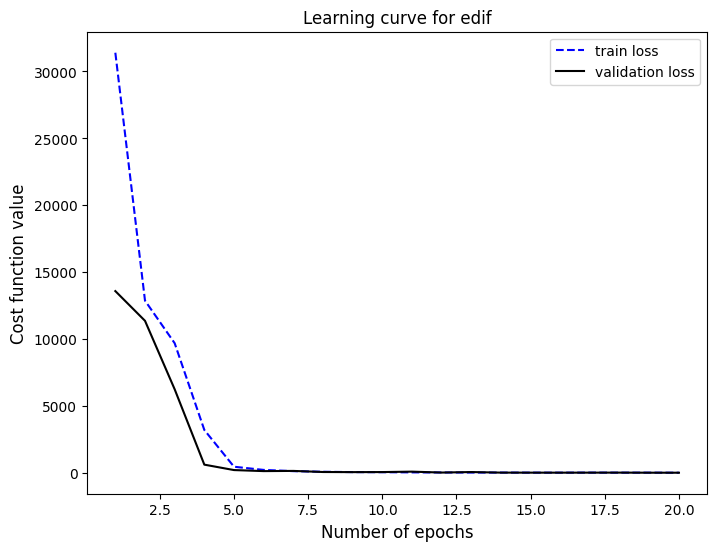

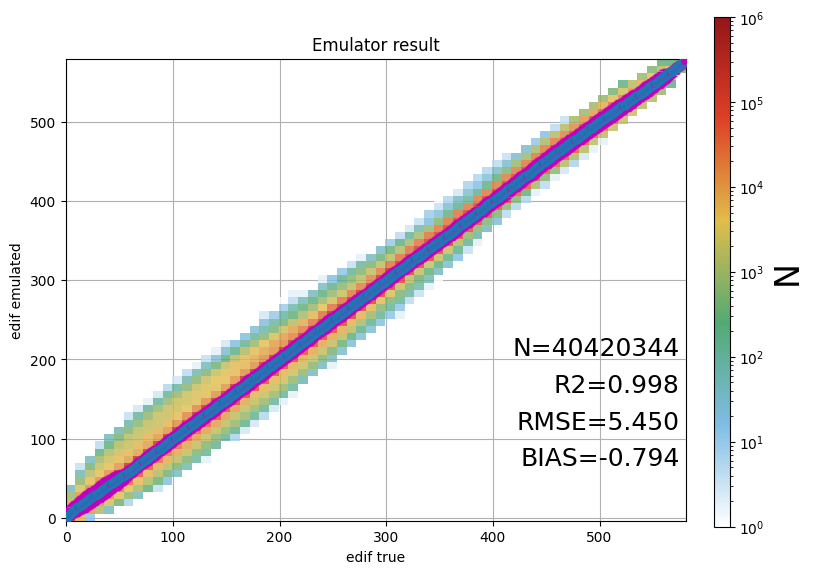

In [151]:
NN_model = model(X_train=scaled_X_train, 
                 Y_train=Y_train_edif,
                 X_val=scaled_X_val,
                 Y_val=Y_val_edif,
                 num_epochs=20,
                 batch_size=32,
                 output_var_name="edif")